In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt, norm 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg

Define functions

In [17]:
def calc_one_zero_error(T,Estimate, ratio = True):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    error = np.sum(~(np.sign(T[np.triu_indices(T.shape[0], k = 1)]) == np.sign(Estimate[np.triu_indices(Estimate.shape[0], k = 1)])))
    if ratio:
        error = error/float(d*(d-1)/2)
    return error

def calc_f1(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.f1_score(y_true,y_pred)

def calc_f1(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.f1_score(y_true,y_pred)

def calc_precision(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.precision_score(y_true,y_pred)

def calc_recall(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.recall_score(y_true,y_pred)

def calc_density(prec):
    tmp = prec.copy()
    np.fill_diagonal(tmp,0)
    G = nx.from_numpy_array(tmp)
    # G = nx.fast_gnp_random_graph(300,0.3)
    return nx.density(G)

def calc_roc(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.recall_score(y_true,y_pred)


def plot_fun1(dict_name, metric, alpha, kappa):
    
    # Plot precision list 
    fig, ax = plt.subplots(2,5, figsize = (20,10))
    l = int(len(alpha)/np.prod(ax.shape))
    a = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):

            metric_loss = []
            if metric == "zero-one":
                for k_idx in range(len(kappa)):
                    loss = np.mean([calc_one_zero_error(dict_name['prec_list'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
            elif metric == "Frobenius":
                for k_idx in range(len(kappa)):
                    loss = np.mean([scipy.linalg.norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro') for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
            elif metric == "l1":
                for k_idx in range(len(kappa)):
                    loss = np.mean([scipy.linalg.norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 1) for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
           

            ax[i,j].plot(kappa,metric_loss)
            if i ==1:
                ax[i,j].set_xlabel("Kappa")
            if j == 0:
                ax[i,j].set_ylabel("loss")
            ax[i,j].set_ylim((0,2))
            ax[i,j].set_title(f"{metric}, alpha:{np.round(alpha[a],3)}")
            a+=l

    fig.show()



def plot_all_metric_per_alpha(dict_name, kappa_vals, ylim = [0,1], bbox_to_anchor = (1,1)):
    from scipy.linalg import norm

     # Plot precision list 
    fig, ax = plt.subplots(1,len(kappa_vals), figsize = (5*len(kappa_vals),5))
    for i, k_idx in enumerate(kappa_vals):
        metric_zo = []
        metric_l1 = []
        metric_f = []
        for a in range(len(dict_name['alpha'])):
            loss = np.mean([calc_one_zero_error(dict_name['prec_list'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec_list']))])
            metric_zo.append(loss)

            loss = np.mean([norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro')/norm(dict_name['prec_list'][k], ord = 'fro') for k in range(len(dict_name['prec_list']))])
            metric_f.append(loss)

            loss = np.mean([norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 1)/norm(dict_name['prec_list'][k], ord = 1) for k in range(len(dict_name['prec_list']))])
            metric_l1.append(loss)

        if len(kappa_vals) == 1:
            ax.plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax.plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax.plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax.set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax.set_xlabel("alpha", fontdict = {'fontsize':24})
            ax.set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax.set_ylim(ylim)
            ax.tick_params(axis='both', which='major', labelsize=20)
            legend  = ax.legend(title = "Metric",fontsize = 14, bbox_to_anchor = bbox_to_anchor)
            legend.get_title().set_fontsize('18')



        else:
            ax[i].plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax[i].plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax[i].plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax[i].set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax[i].set_xlabel("alpha", fontdict = {'fontsize':24})
            if i == 0:
                ax[i].set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax[i].set_ylim(ylim)
            if i == len(kappa_vals)-1:
                #ax[i].legend(bbox_to_anchor = (1.4,1))
                legend  = ax[i].legend(title = "Metric",fontsize = 18, bbox_to_anchor = bbox_to_anchor)
                legend.get_title().set_fontsize('18')

            ax[i].tick_params(axis='both', which='major', labelsize=20)


def plot_edges(list_of_dicts, edges, alpha_idx, kappa_idx):

    # red grey green blue
    colors_light = ['black', '#D0CDC9', '#6EA96E', '#D6F6F6']
    colors_dark = ['#CC1100', '#8B7500','#00688B', '#00688B']

    fig, ax = plt.subplots(1,len(edges), figsize = (5*len(edges),5))

    plot_once_edge = True
    for cnt1, dict_name in enumerate(list_of_dicts):

        d = dict_name['theta'][0][0].shape[1]


        
        for cnt2, e in enumerate(edges):

            if len(edges) == 1:
                if plot_once_edge:
                    ax.plot(dict_name['prec_list'][:,e[0],e[1]], label = "True", color = colors_light[0])
                
                ax.set_title(f"Edge ({e[0]+1}, {e[1]+1}), alpha= {np.round(dict_name['alpha'][alpha_idx],2)}, kappa =  {np.round(dict_name['kappa'][kappa_idx],2)}")
                    
                ax.plot(dict_name['theta'][alpha_idx][kappa_idx][:,e[0],e[1]], label = f"Estimate, n={dict_name['nr_obs_per_graph']}", linestyle = '--', color = colors_dark[cnt1])
                
                ax.legend(bbox_to_anchor = (1,1))
                ax.set_xlabel("Time")
                ax.set_ylabel("Edge weight")
            else:
                if plot_once_edge:
                    ax[cnt2].plot(dict_name['prec_list'][:,e[0],e[1]], label = "True", color = colors_light[0])
                
                ax[cnt2].set_title(f"Edge ({e[0]+1}, {e[1]+1}), alpha= {np.round(dict_name['alpha'][alpha_idx],2)}, kappa =  {np.round(dict_name['kappa'][kappa_idx],2)}")

                ax[cnt2].plot(dict_name['theta'][alpha_idx][kappa_idx][:,e[0],e[1]], label = f"Estimate, n={dict_name['nr_obs_per_graph']}", linestyle = '--', color = colors_dark[cnt1])
                 
                if cnt2 == len(edges)-1:
                    ax[cnt2].legend(bbox_to_anchor = (1,1))
                ax[cnt2].set_xlabel("Time")
                ax[cnt2].set_ylabel("Edge weight")

        plot_once_edge = False


def find_min(change_point_dict):
    from scipy.linalg import norm
    # Find which gives minimum
    current_min_zo = np.inf
    edge_min_zo = [0,0]

    current_min_l1 = np.inf
    edge_min_l1 = [0,0]

    current_min_f = np.inf
    edge_min_f = [0,0]


    for i in range(len(change_point_dict['alpha'])):
        for j in range(len(change_point_dict['kappa'])):
            
            loss = np.mean([calc_one_zero_error(change_point_dict['prec_list'][k], change_point_dict['theta'][i][j][k]) for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_zo:
                current_min_zo = loss

                edge_min_zo[0] = i
                edge_min_zo[1] = j

            loss = np.mean([norm(change_point_dict['prec_list'][k]- change_point_dict['theta'][i][j][k],ord = 'fro')/norm(change_point_dict['prec_list'][k], ord = 'fro') for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_f:
                current_min_f = loss

                edge_min_f[0] = i
                edge_min_f[1] = j

            loss = np.mean([norm(change_point_dict['prec_list'][k]- change_point_dict['theta'][i][j][k],ord = 1)/norm(change_point_dict['prec_list'][k], ord = 'fro') for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_l1:
                current_min_l1 = loss

                edge_min_l1[0] = i
                edge_min_l1[1] = j



    print(f"zo {edge_min_zo} {current_min_zo}")
    print(f"l1 {edge_min_l1}  {current_min_l1}")
    print(f"F {edge_min_f}  {current_min_f}")


Define seed matrices

In [3]:
from sklearn.datasets import make_sparse_spd_matrix
prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.2, largest_coef=0.8, norm_diag = True,random_state=42)
print("precision")
print(prec_0)
print("Covariance")
S = np.linalg.inv(prec_0)
print(S)

precision
[[ 1.          0.          0.13373616  0.         -0.54739138]
 [ 0.          1.          0.          0.09171019 -0.31028148]
 [ 0.13373616  0.          1.          0.         -0.5042745 ]
 [ 0.          0.09171019  0.          1.          0.        ]
 [-0.54739138 -0.31028148 -0.5042745   0.          1.        ]]
Covariance
[[ 1.59497689  0.36930761  0.38185046 -0.03386927  1.18022337]
 [ 0.36930761  1.24495262  0.33169356 -0.11417484  0.75570615]
 [ 0.38185046  0.33169356  1.48347252 -0.03041968  1.06001739]
 [-0.03386927 -0.11417484 -0.03041968  1.010471   -0.06930595]
 [ 1.18022337  0.75570615  1.06001739 -0.06930595  2.41506546]]


# Read data

In [34]:
# Read
import pickle
te = 'global-reconstruction'
with open(f'../data/single/single_change_gaussian_{te}_90_10_1e-10.pkl', 'rb') as handle:
    change_point_dict1 = pickle.load(handle)
with open(f'../data/single/single_change_gaussian_{te}_450_50_1e-10.pkl', 'rb') as handle:
    change_point_dict2 = pickle.load(handle)
with open(f'../data/single/single_change_gaussian_{te}_900_100_1e-10.pkl', 'rb') as handle:
    change_point_dict3 = pickle.load(handle)

Find minimum

In [35]:
find_min(change_point_dict3)

zo [15, 0] 0.13333333333333336
l1 [0, 16]  0.09174920841973538
F [0, 11]  0.08192725085391232


Plot loss metrics

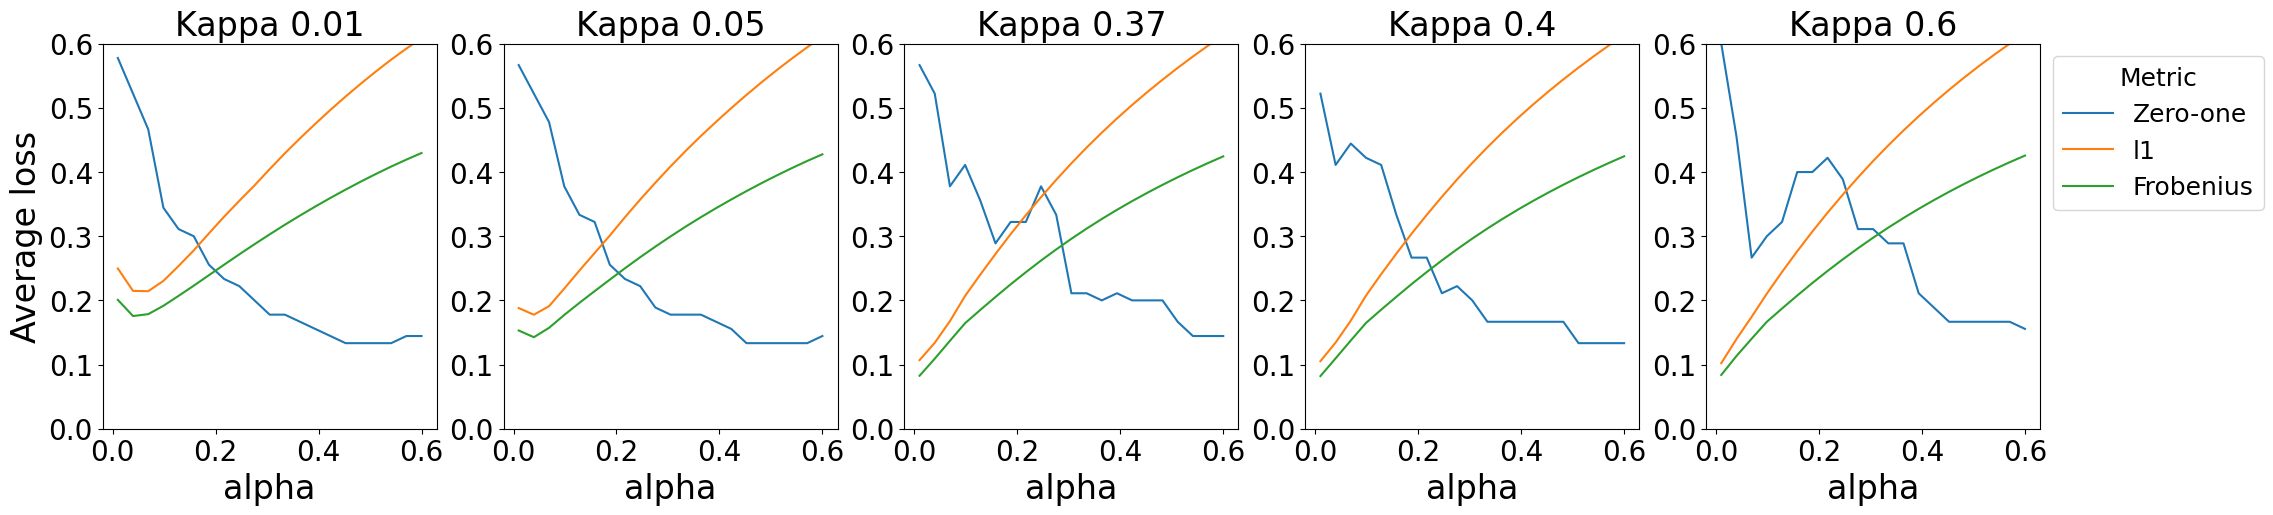

In [36]:
plot_all_metric_per_alpha(change_point_dict3, [0,1,9,10,15], ylim=[0,0.6])

Plot edges

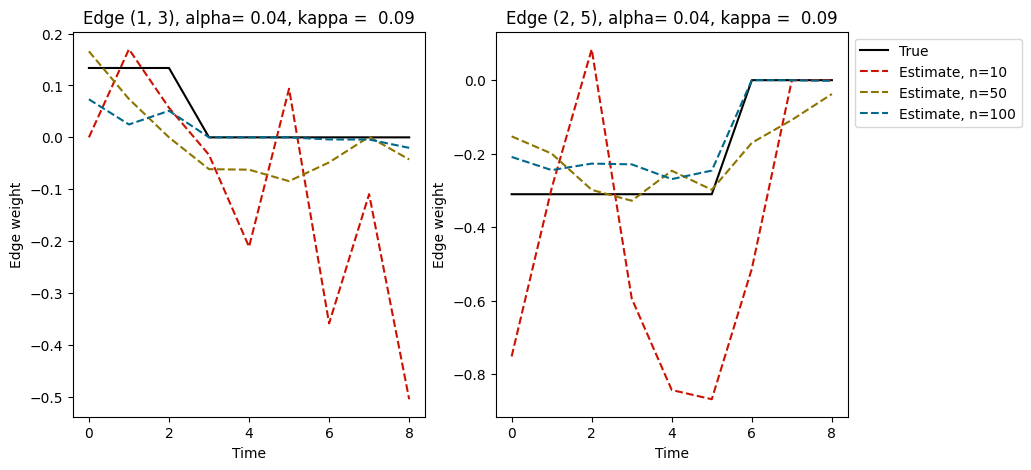

In [39]:
plot_edges([change_point_dict1, change_point_dict2, change_point_dict3], [(0,2), (1,4)], 1, 2)

find minimum

In [57]:
find_min(change_point_dict3)

zo [19, 7] 0.3333333333333333
l1 [0, 10]  0.08279998945662487
F [0, 8]  0.06740634049565375


test code

In [5]:
from sklearn.datasets import make_sparse_spd_matrix
prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.2, largest_coef=0.8, norm_diag = True,random_state=42)
#print("precision")
# print(prec_0)
#print("Covariance")
S = np.linalg.inv(prec_0)
#print(S)




rnd_state = np.random.RandomState(42)
rnd_state2 = np.random.RandomState(1)
nr_obs_per_graph = 100
n = 9*nr_obs_per_graph
d = prec_0.shape[0]
# Simulate 
Xs = np.zeros((n,d))
prec_list = [prec_0]
is_psd = False
cnt = 0
while cnt*nr_obs_per_graph <n:
    if cnt > 0:
        prec_tmp = prec_list[cnt-1].copy()
        # # element to change
        # i = 0#np.random.randint(0,d)
        # j = rnd_state.randint(0,d)
        # if i == j:
        #     continue
        # if rnd_state.uniform() < 0.8:
        #     prec_tmp[i,j] = 0.0
        #     prec_tmp[j,i] = 0.0
        # else:
        #     w = rnd_state.uniform(-0.5, 0.5)
        #     prec_tmp[i,j] = w
        #     prec_tmp[j,i] = w

        if cnt in [3,4,5]:
            prec_tmp[0,2] = 0.0
            prec_tmp[2,0] = 0.0
        if cnt in [6,7,8]:
            prec_tmp[4,1] = 0.0
            prec_tmp[1,4] = 0.0

        
        u,v = np.linalg.eigh(prec_tmp)
        if np.any(u<0.0):
            continue
        prec_list.append(prec_tmp)

    Xs[cnt*nr_obs_per_graph:(cnt+1)*nr_obs_per_graph ] = rnd_state2.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(prec_list[cnt]),size=(nr_obs_per_graph) )

    cnt +=1



obs_per_graph_model = nr_obs_per_graph


dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph_model, max_iter = 2000, lamda = obs_per_graph_model*0.09, kappa = obs_per_graph_model*0.4, tol = 1e-10)
dg_opt1.fit(Xs, nr_workers=10, temporal_penalty="block-wise-reconstruction", lik_type="gaussian", verbose=True)



tmp_F = []
tmp_zo = []
tmp_l1 = []
for k in range(len(prec_list)):

    tmp_zo.append(calc_one_zero_error(prec_list[k], dg_opt1.theta[k]))
    tmp_F.append(scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k],ord = 'fro'))
    tmp_l1.append(scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k],ord = 1))


F_error = np.mean(tmp_F)
one_zero_error = np.mean(tmp_zo)
l1_error = np.mean(tmp_l1)

print(f"F {F_error}")
print(f"z0 {one_zero_error}")
print(f"l1 {l1_error}")



Error 2.40E-9: 100%|█████████▉| 1999/2000 [01:32<00:00, 21.80it/s]C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:405: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")
Error 2.40E-9: 100%|██████████| 2000/2000 [01:32<00:00, 21.51it/s]

F 0.40821638555135503
z0 0.38888888888888884
l1 0.46946403303705153


In [89]:
dg_opt1.iteration

2000

In [28]:
np.linspace(0.01, 0.6,21)

array([0.01  , 0.0395, 0.069 , 0.0985, 0.128 , 0.1575, 0.187 , 0.2165,
       0.246 , 0.2755, 0.305 , 0.3345, 0.364 , 0.3935, 0.423 , 0.4525,
       0.482 , 0.5115, 0.541 , 0.5705, 0.6   ])

In [351]:
tmp_zo

[0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7]

In [342]:
tmp_zo

[0.7]

In [339]:
tmp_zo

[0.7]

In [337]:
dg_opt1.theta[k]

array([[ 8.69438458e-01, -3.06767757e-05, -2.84182468e-05,
         2.77021052e-03, -4.50341807e-01],
       [-3.06767757e-05,  9.28385223e-01, -4.62615432e-06,
         3.65581975e-02, -2.56863683e-05],
       [-2.84182468e-05, -4.62615432e-06,  9.67895238e-01,
         1.97740899e-05, -4.41470579e-01],
       [ 2.77021052e-03,  3.65581975e-02,  1.97740899e-05,
         9.54426392e-01,  4.16676021e-05],
       [-4.50341807e-01, -2.56863683e-05, -4.41470579e-01,
         4.16676021e-05,  9.03924264e-01]])

Loss metrics

In [258]:
# plot_fun1(change_point_dict, "zero-one", change_point_dict['alpha'], change_point_dict['kappa'])
# plot_fun1(change_point_dict, "Frobenius", change_point_dict['alpha'], change_point_dict['kappa'])
# plot_fun1(change_point_dict, "l1", change_point_dict['alpha'], change_point_dict['kappa'])


plot edges

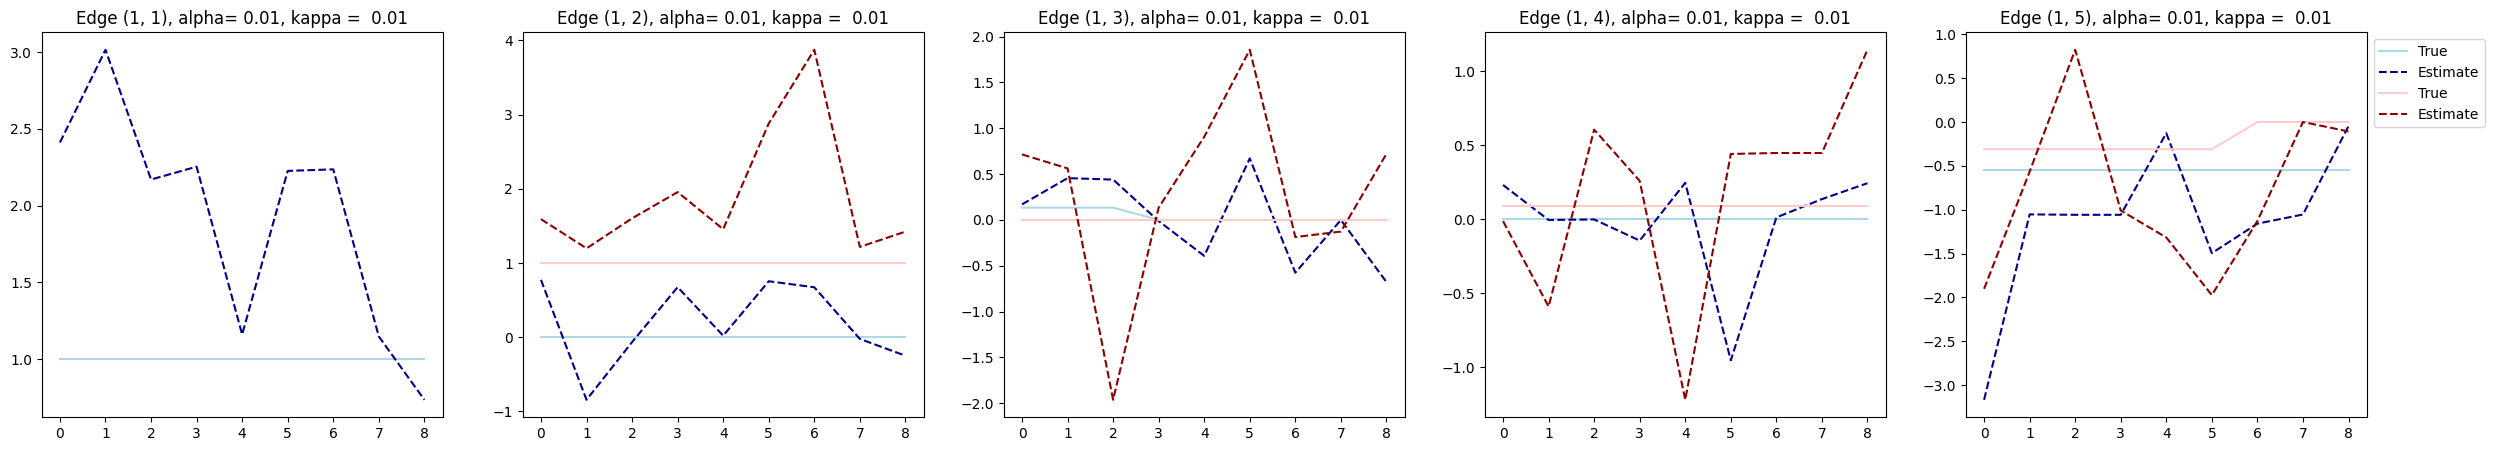

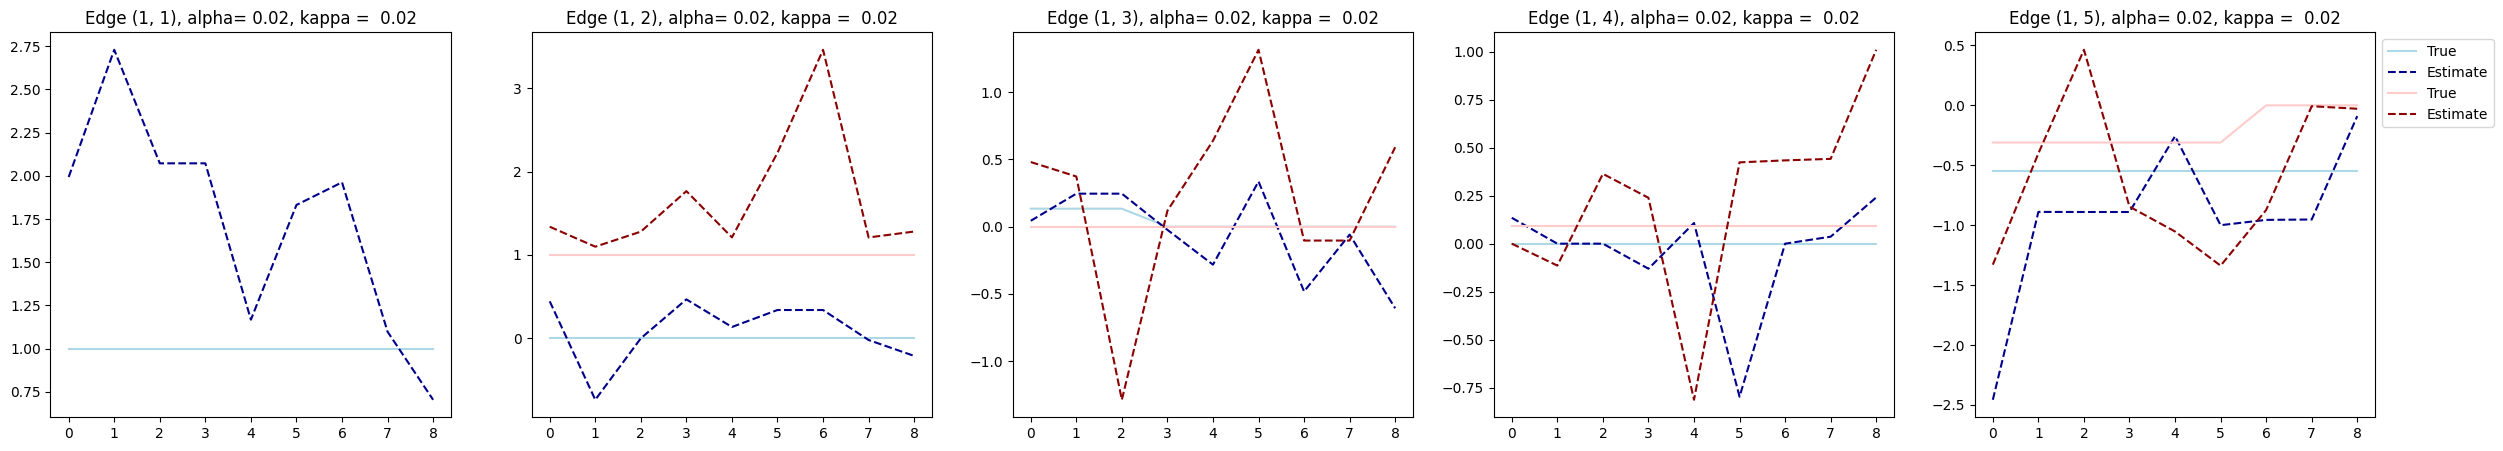

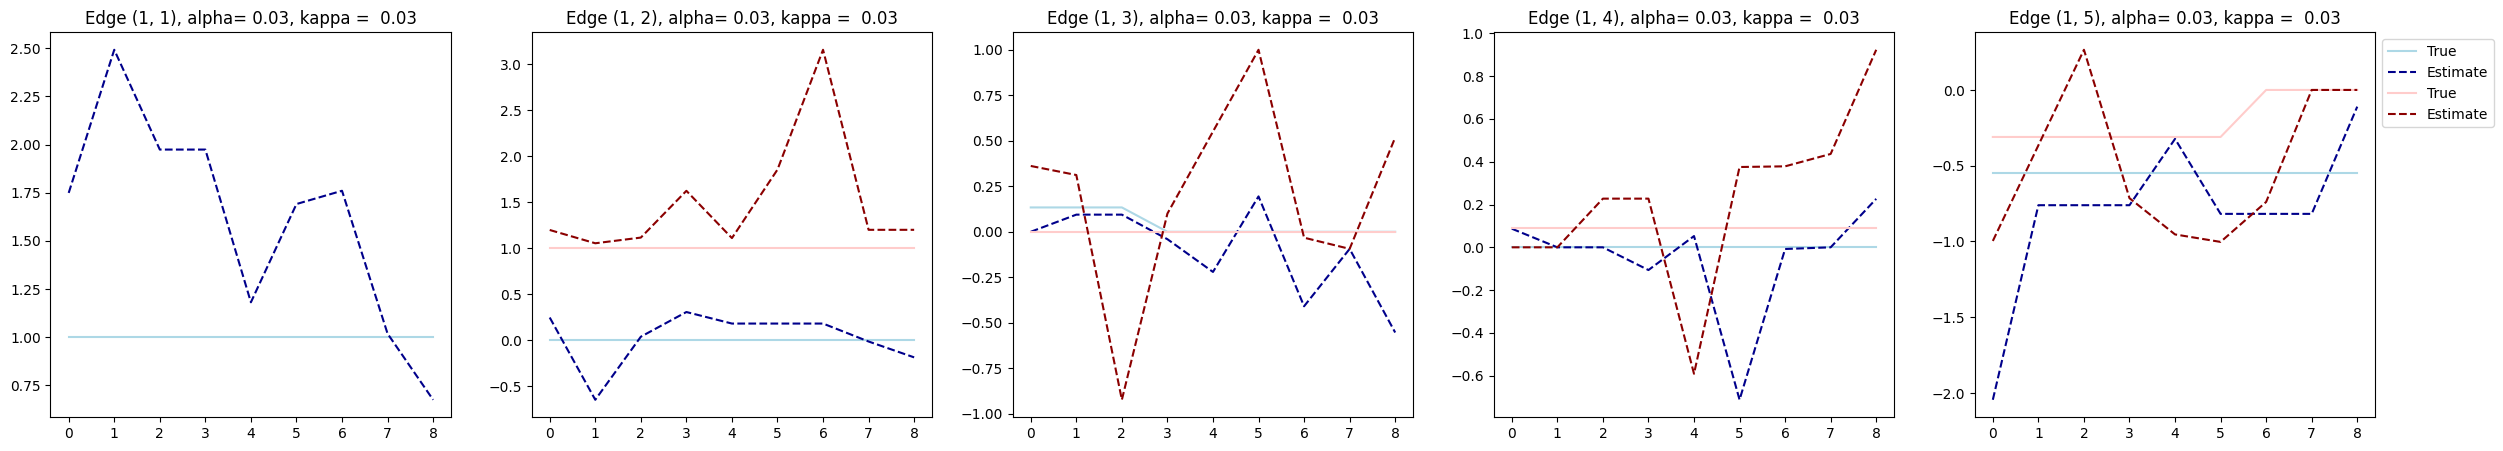

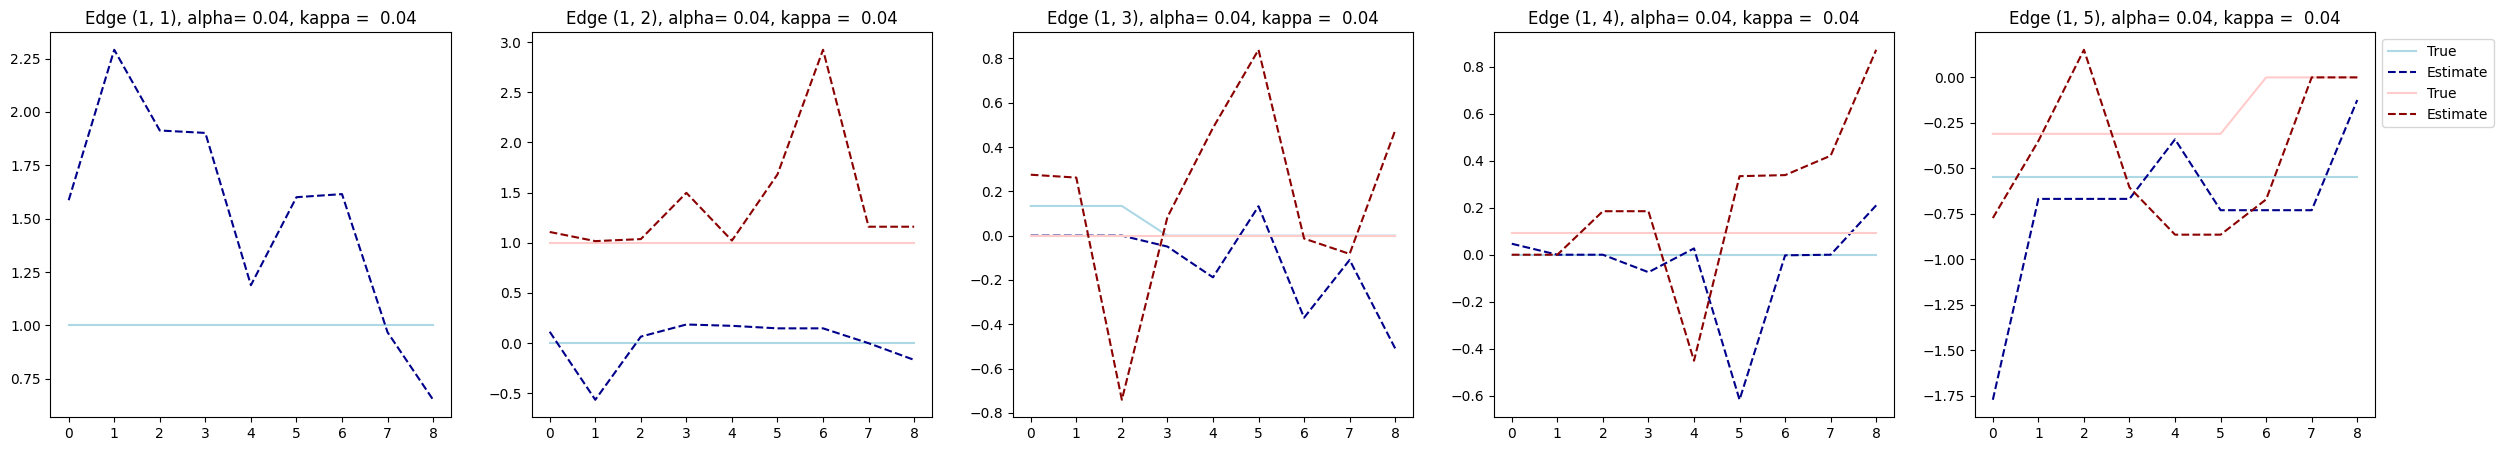

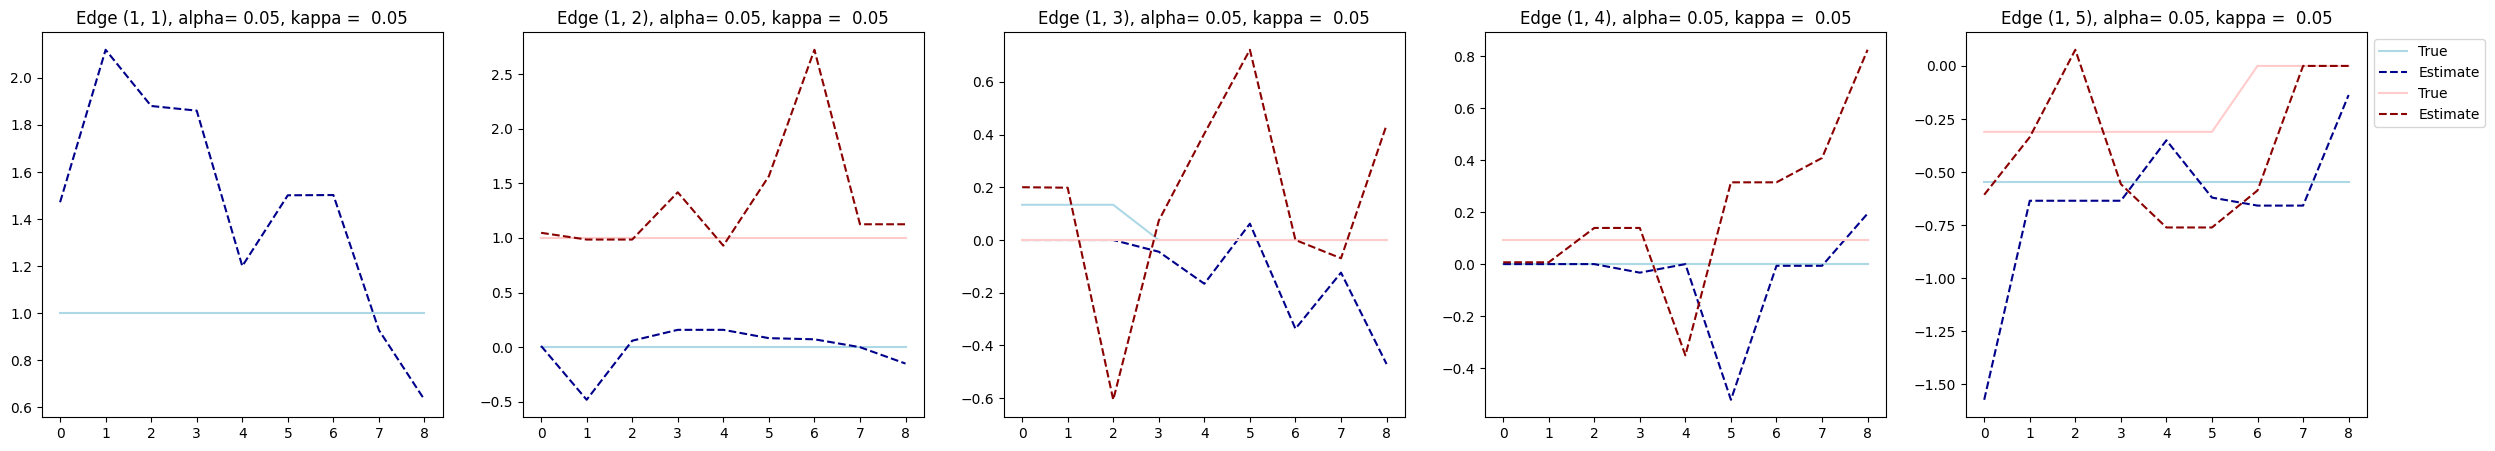

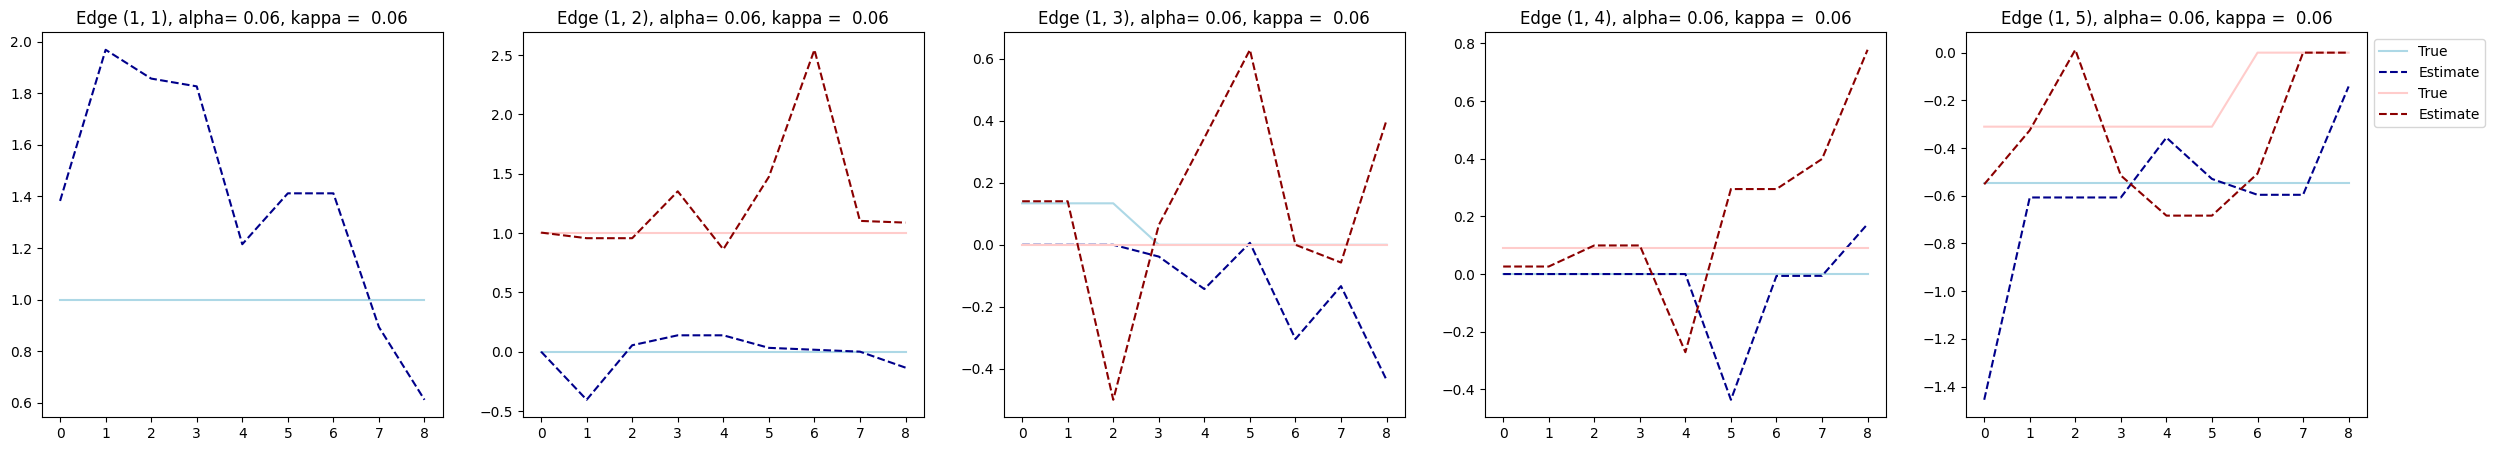

In [167]:
# d = change_point_dict['theta'][0][0].shape[1]

# l = len(change_point_dict['theta'].keys())
# for cnt, j in enumerate(range(0, l, int(l/5))):

#     fig, ax = plt.subplots(1,5, figsize = (30,5))

#     for i in range(d):
#         ax[i].plot(change_point_dict['prec_list'][:,0,i], label = "True", color = 'lightblue')
#         ax[i].plot(change_point_dict['theta'][cnt][cnt][:,0,i], label = "Estimate", linestyle = '--', color = 'darkblue')
#         if i >0:
#             ax[i].plot(change_point_dict['prec_list'][:,1,i], label = "True", color = '#FFCCCB')
#             ax[i].plot(change_point_dict['theta'][cnt][cnt][:,1,i], label = "Estimate", linestyle = '--', color = '#8b0000')

#         if i == d-1:
#             ax[i].legend(bbox_to_anchor = (1,1))
#         ax[i].set_title(f"Edge ({1}, {i+1}), alpha= {np.round(change_point_dict['alpha'][cnt],2)}, kappa =  {np.round(change_point_dict['kappa'][cnt],2)}")

[7, 23]
[2, 22]
[0, 22]


Text(0.5, 1.0, 'Edge (2, 5), alpha= 0.08, kappa =  0.33')

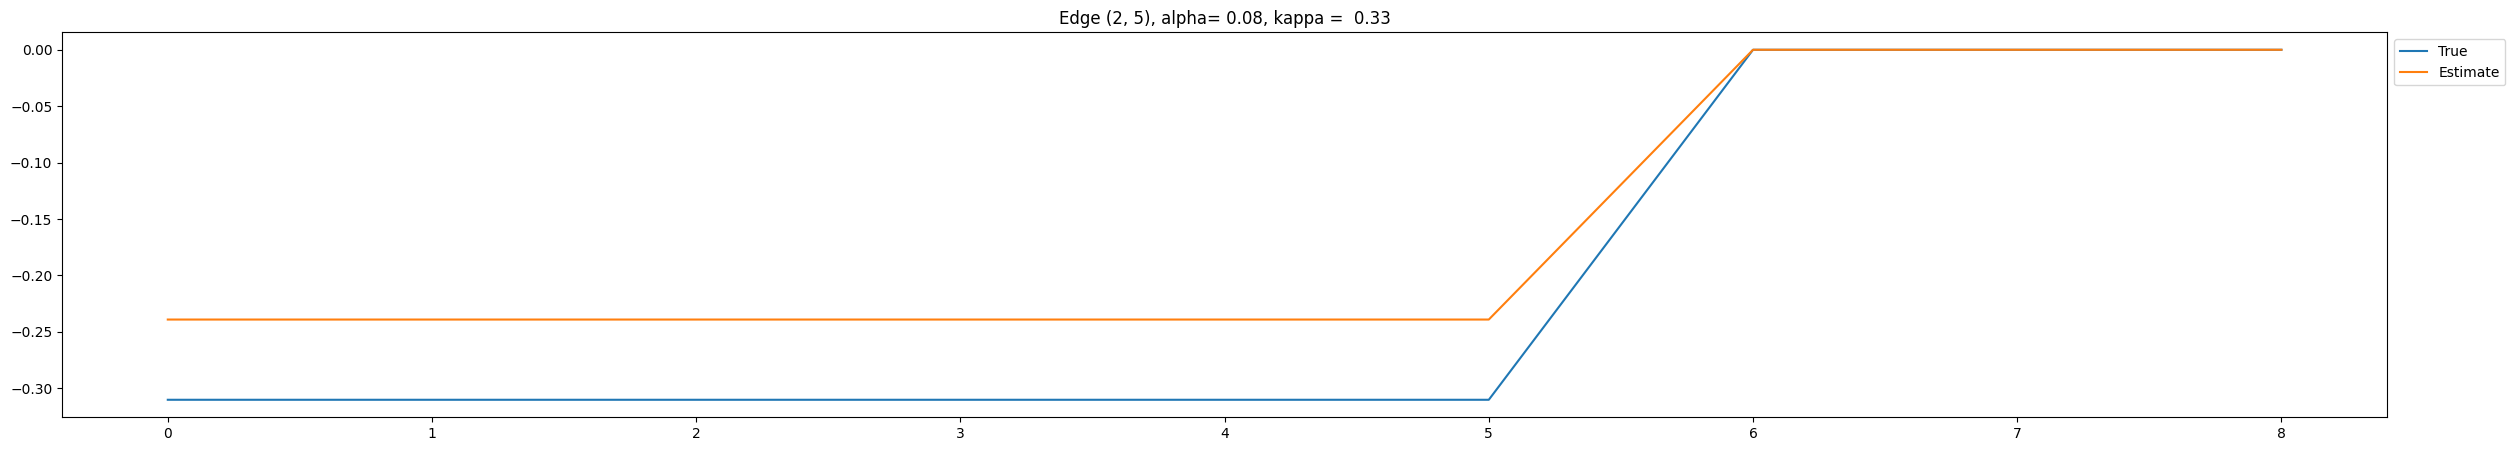

In [181]:
d = change_point_dict['theta'][0][0].shape[1]
a_idx = 7
k_idx = 23
fig, ax = plt.subplots(1,1, figsize = (30,5))
i = 1
j = 4
ax.plot(change_point_dict['prec_list'][:,i,j], label = "True")
ax.plot(change_point_dict['theta'][a_idx][k_idx][:,i,j], label = "Estimate")

ax.legend(bbox_to_anchor = (1,1))
ax.set_title(f"Edge ({i+1}, {j+1}), alpha= {np.round(change_point_dict['alpha'][a_idx],2)}, kappa =  {np.round(change_point_dict['kappa'][k_idx],2)}")

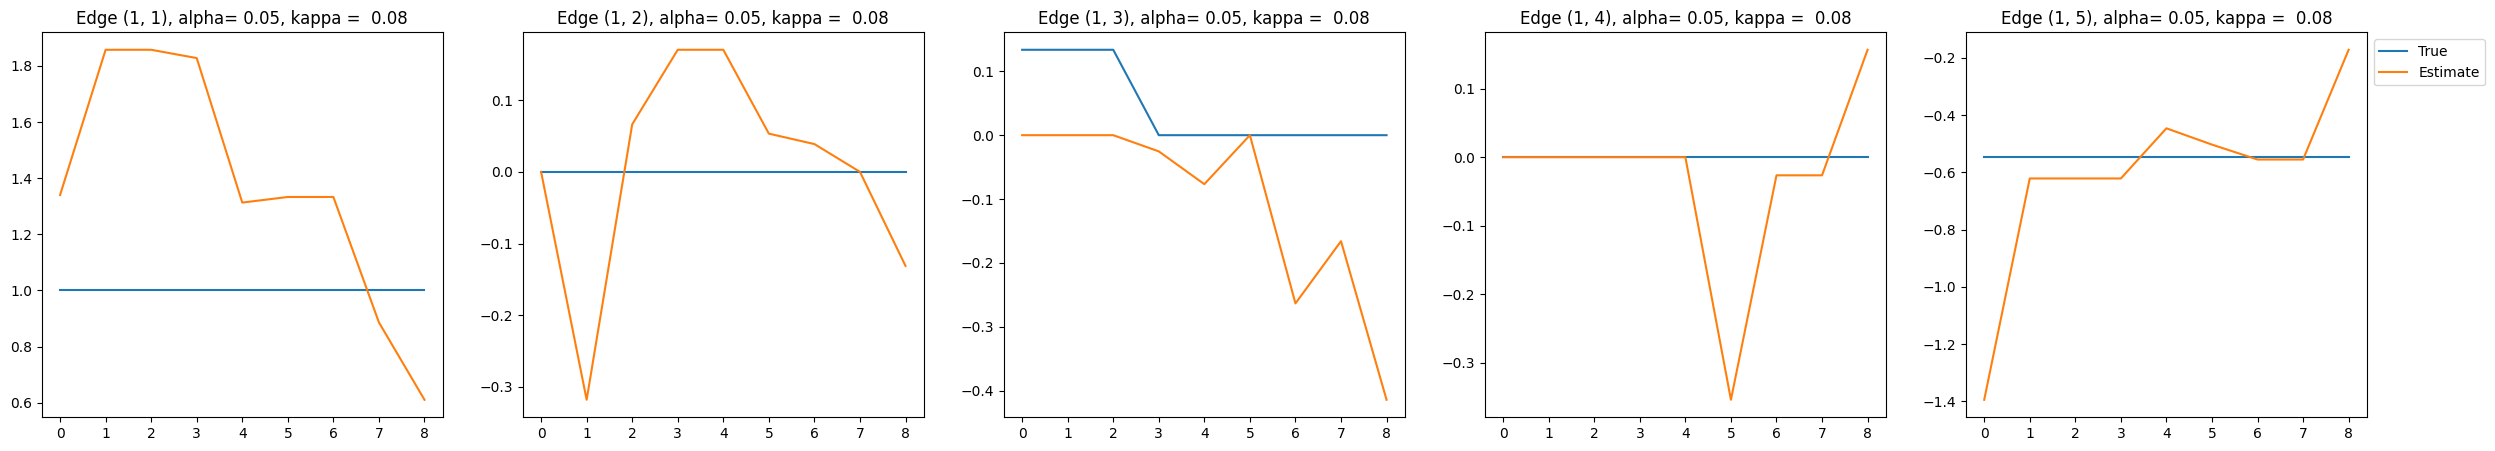

In [127]:
d = change_point_dict['theta'][0][0].shape[1]
a_idx = 4
k_idx = 7
fig, ax = plt.subplots(1,5, figsize = (30,5))
for i in range(d):
    ax[i].plot(change_point_dict['prec_list'][:,0,i], label = "True")
    ax[i].plot(change_point_dict['theta'][a_idx][k_idx][:,0,i], label = "Estimate")
    if i == d-1:
        ax[i].legend(bbox_to_anchor = (1,1))
    ax[i].set_title(f"Edge ({1}, {i+1}), alpha= {np.round(change_point_dict['alpha'][a_idx],2)}, kappa =  {np.round(change_point_dict['kappa'][k_idx],2)}")

# Single Element changes

Generate 1000 obsrvations where changes occur every 20 steps.

In [180]:
rnd_state = np.random.RandomState(42)
rnd_state2 = np.random.RandomState(1)


nr_obs_per_graph = 50
n = 20*nr_obs_per_graph
d = prec_0.shape[0]
# Simulate 
Xs = np.zeros((n,d))
prec_list = [prec_0]
is_psd = False
cnt = 0
while cnt*nr_obs_per_graph <n:
    if cnt > 0:
        prec_tmp = prec_list[cnt-1].copy()
        if rnd_state.uniform() < 0.6:
            for j in range(1,d):
                if rnd_state.uniform() <0.5:
                    prec_tmp[0,j] = prec_tmp[0,0]*rnd_state.uniform(0.2, 0.4)
                    prec_tmp[j,0] = prec_tmp[0,j]
                else:
                    prec_tmp[0,j] = 0.0
                    prec_tmp[j,0] = 0.0
        else:
            for j in range(1,d):
                if rnd_state.uniform() <0.6:
                    prec_tmp[0,j] = prec_tmp[0,0]*rnd_state.uniform(0.6, 0.8)
                    prec_tmp[j,0] = prec_tmp[0,j]
    
        
        u,v = np.linalg.eigh(prec_tmp)
        if np.any(u<0.0):
            continue
        prec_list.append(prec_tmp)

    Xs[cnt*nr_obs_per_graph:(cnt+1)*nr_obs_per_graph ] = rnd_state2.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(prec_list[cnt]),size=(nr_obs_per_graph) )

    cnt +=1





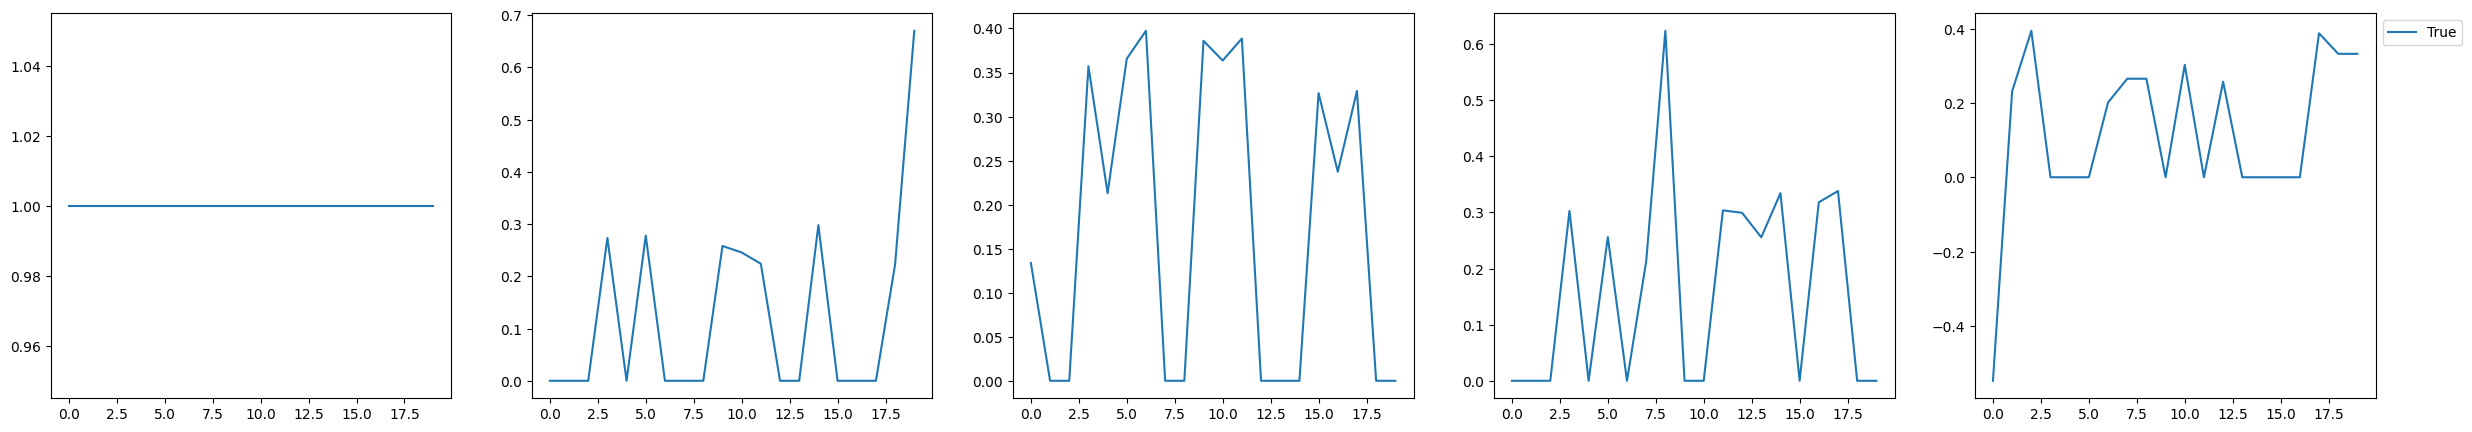

In [181]:
prec_list = np.array(prec_list)
fig, ax = plt.subplots(1,5, figsize = (30,5))

for i in range(d):
    ax[i].plot(prec_list[:,0,i], label = "True")
    if i == d-1:
        ax[i].legend(bbox_to_anchor = (1,1))

In [ ]:

prec_list = np.array(prec_list)



alpha = np.linspace(0,0.6, 61)
kappa = np.linspace(0,0.6, 61)


pbar = tqdm.tqdm(total = len(alpha)*len(kappa))

theta = {i:[] for i in range(len(alpha))}
l1_error = {i:[] for i in range(len(alpha))}
F_error = {i:[] for i in range(len(alpha))}
one_zero_error = {i:[] for i in range(len(alpha))}


obs_per_graph_model = nr_obs_per_graph
for i in range(len(alpha)):
    for j in range(len(kappa)):

        dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph_model, max_iter = 1000, lamda = obs_per_graph_model*alpha[i], kappa = obs_per_graph_model*kappa[j], tol = 1e-6)
        dg_opt1.fit(Xs, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian", verbose=False)

        theta[i].append(dg_opt1.theta)


        for k in range(int(n/obs_per_graph_model)):
            tmp_F = []
            tmp_zo = []
            tmp_l1 = []

            tmp_zo.append(calc_one_zero_error(prec_list[k], dg_opt1.theta[k]))
            tmp_F.append(scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k],ord = 1))


        F_error[i].append(np.mean(tmp_F))
        one_zero_error[i].append(np.mean(tmp_zo))
        l1_error[i].append(np.mean(tmp_l1))

        pbar.set_description(f"{i} {j}")
        pbar.update()


## Plot metrics

In [71]:
np.linspace(0,0.6, 31)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 ])

In [188]:
# Read
import pickle
with open(f'../data/single_change_gaussian2_element-wise_1000_50.pkl', 'rb') as handle:
    change_point_dict = pickle.load(handle)

In [183]:
def plot_fun1(metric_dict, name, alpha, kappa):
    
    # Plot precision list 
    fig, ax = plt.subplots(2,5, figsize = (20,10))
    l = int(len(alpha)/np.prod(ax.shape))
    a = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):

            ax[i,j].plot(kappa, metric_dict[a])
            if i ==1:
                ax[i,j].set_xlabel("Kappa")
            if j == 0:
                ax[i,j].set_ylabel("loss")
            ax[i,j].set_ylim((0,2))
            ax[i,j].set_title(f"{name}, alpha:{np.round(alpha[a],2)}")
            a+=l

    fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_16536\3412304521.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


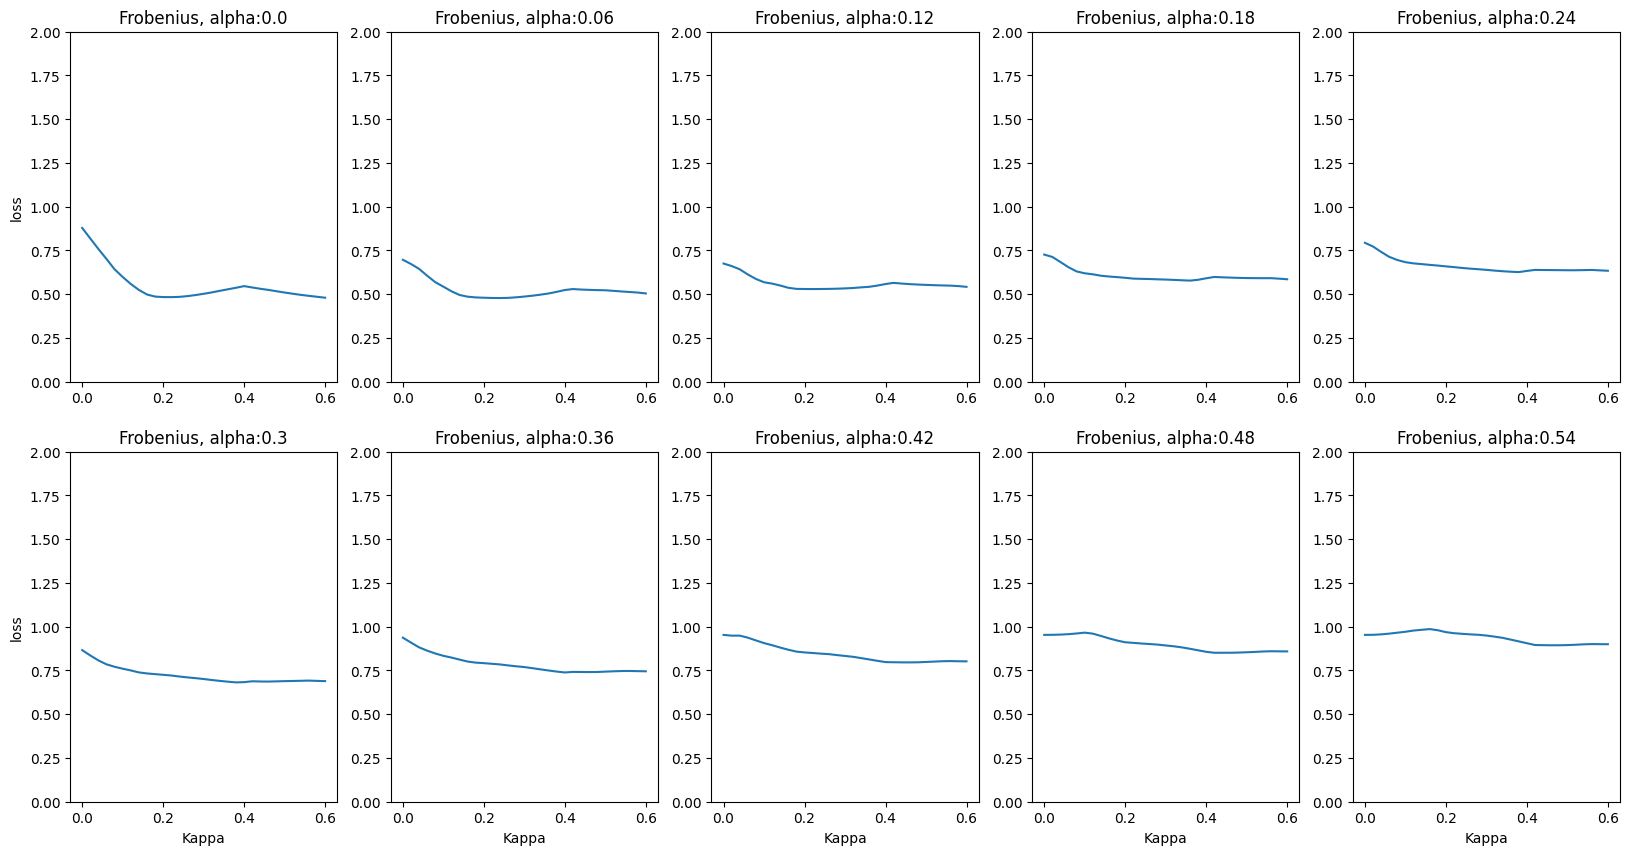

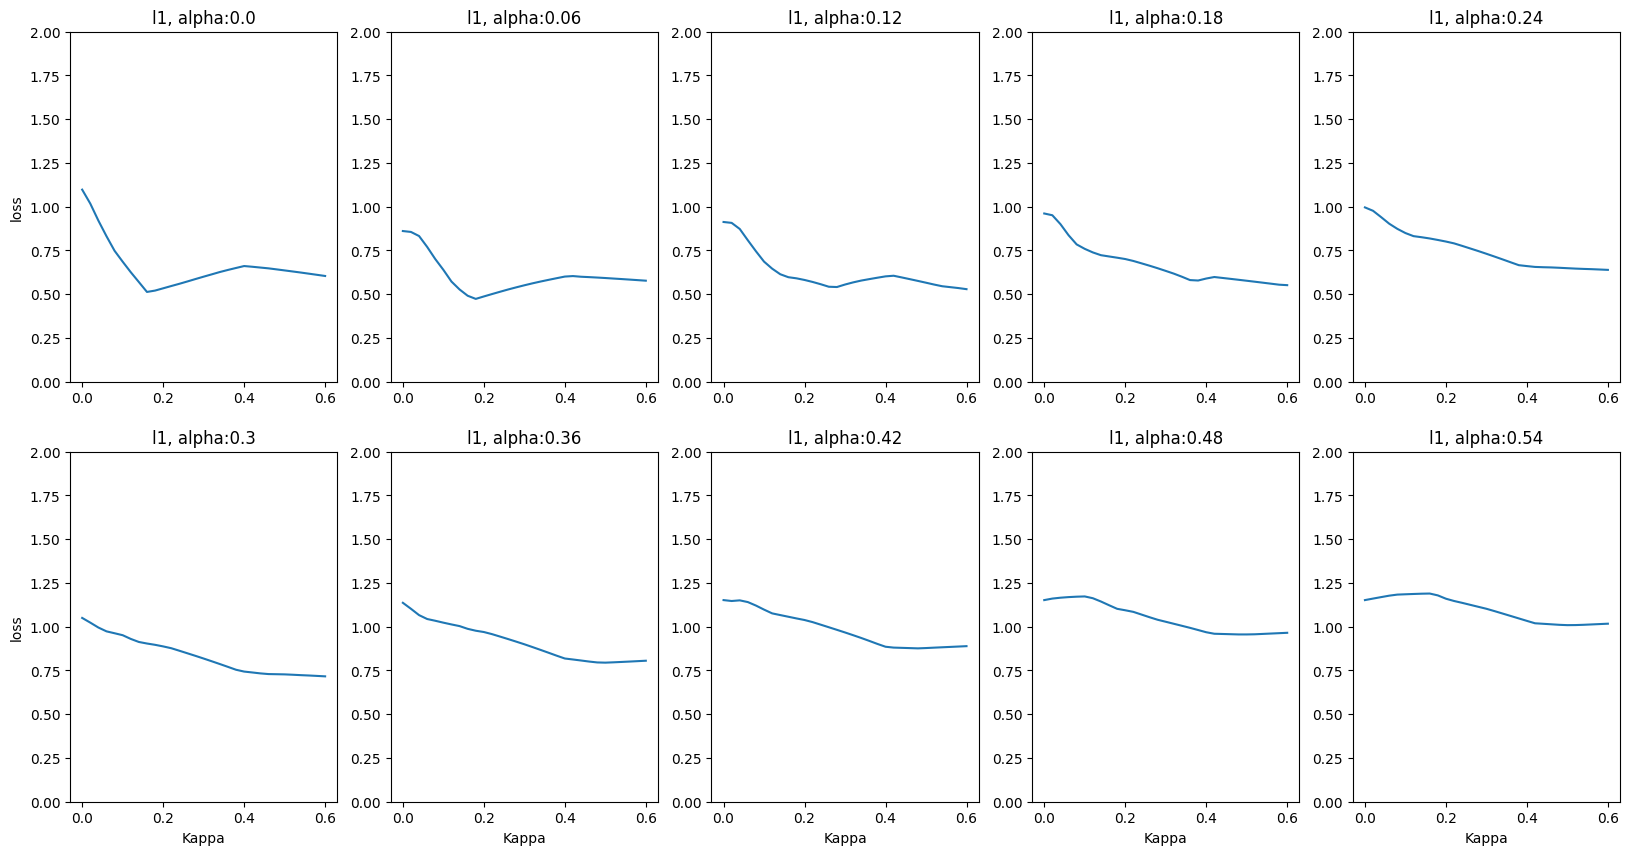

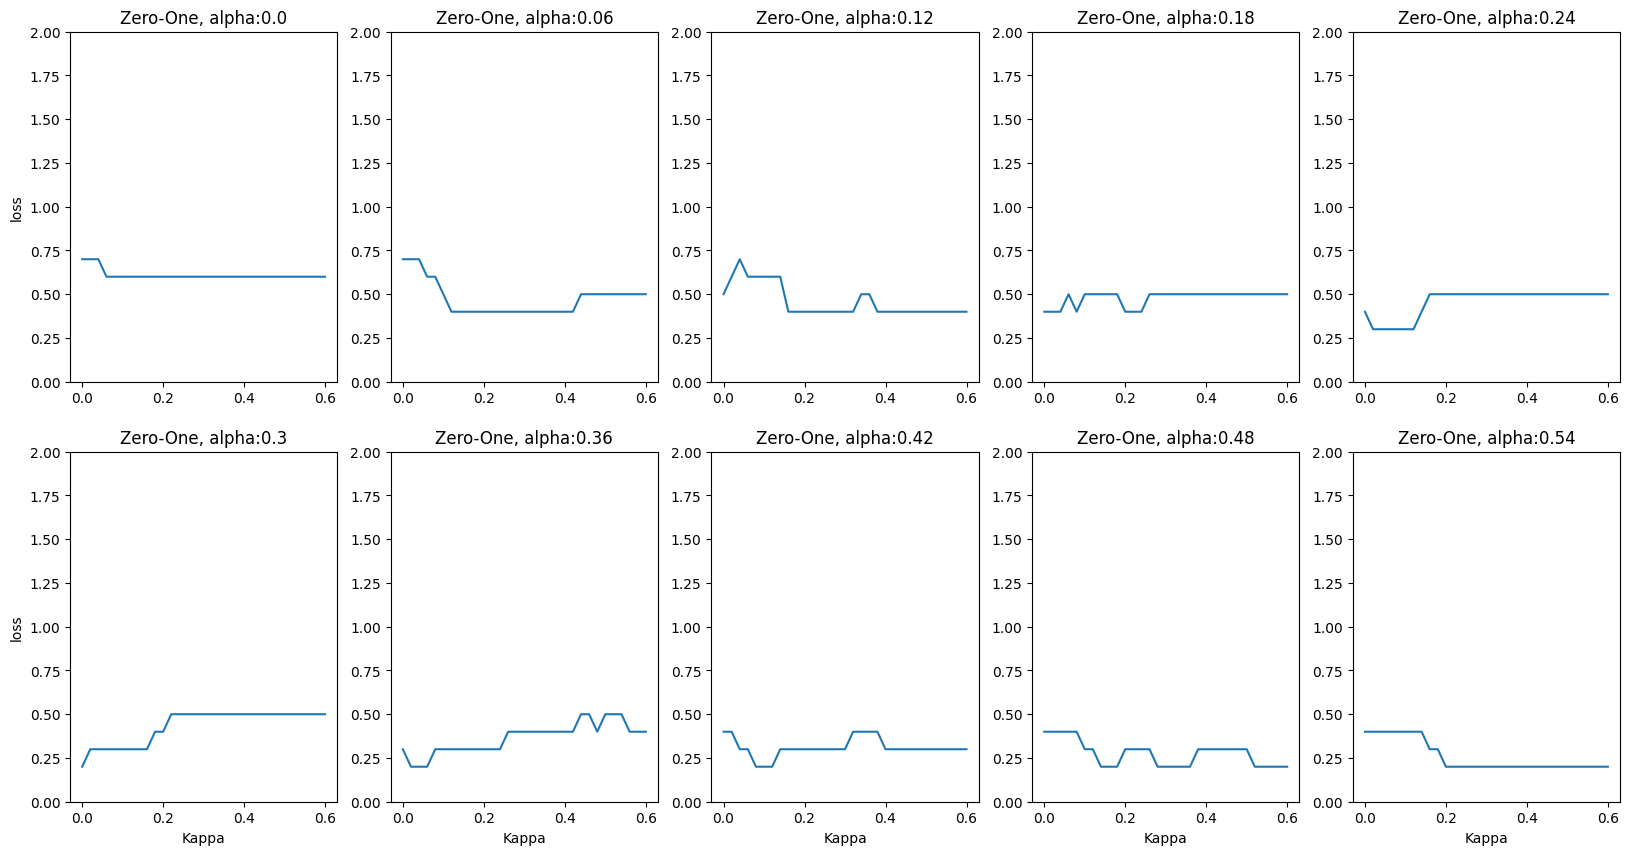

In [184]:
plot_fun1(change_point_dict['F_error'], "Frobenius", change_point_dict['alpha'], change_point_dict['kappa'])
plot_fun1(change_point_dict['l1_error'] ,"l1", change_point_dict['alpha'], change_point_dict['kappa'])
plot_fun1(change_point_dict['one_zero_error'], "Zero-One", change_point_dict['alpha'], change_point_dict['kappa'])

## Plot edge changes

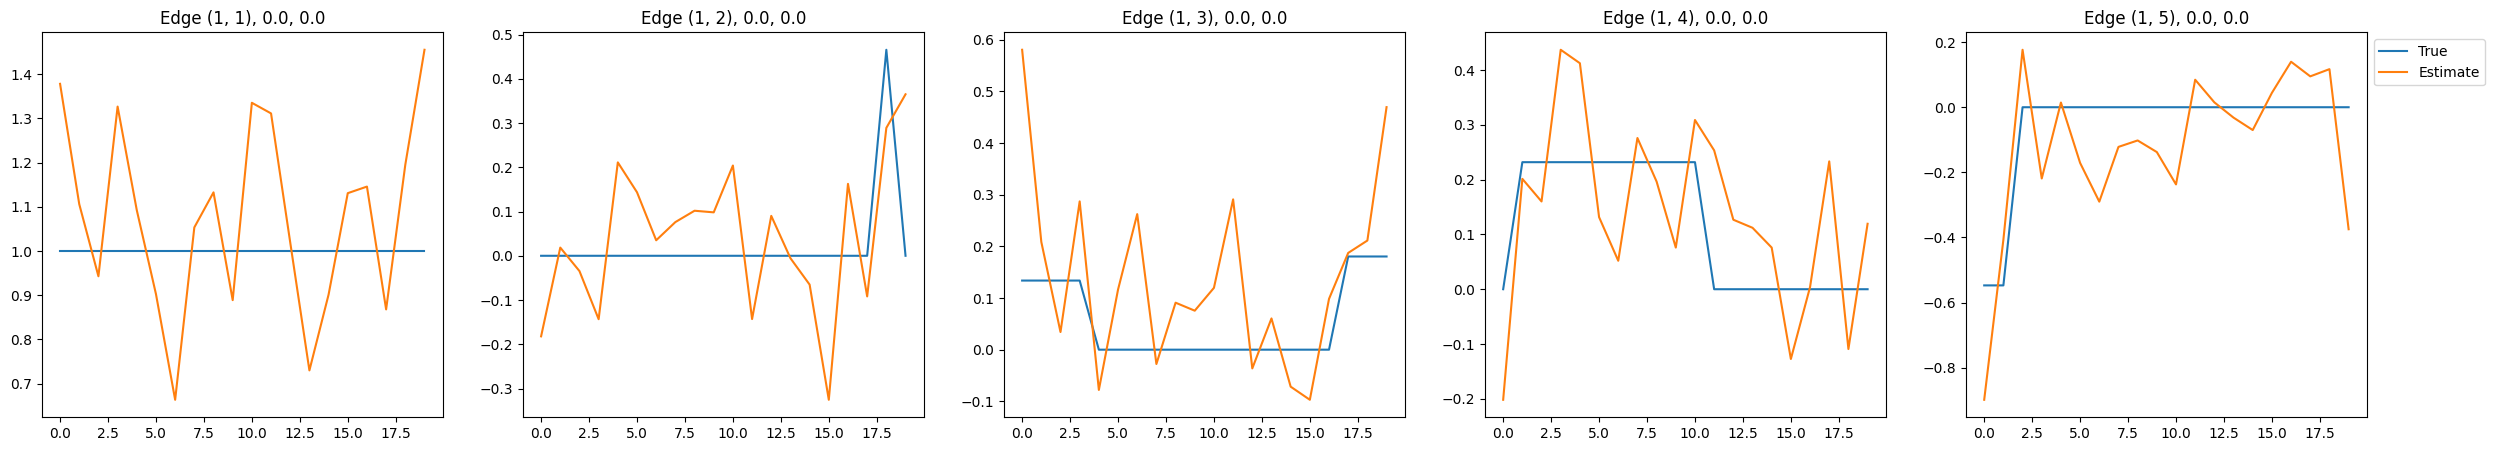

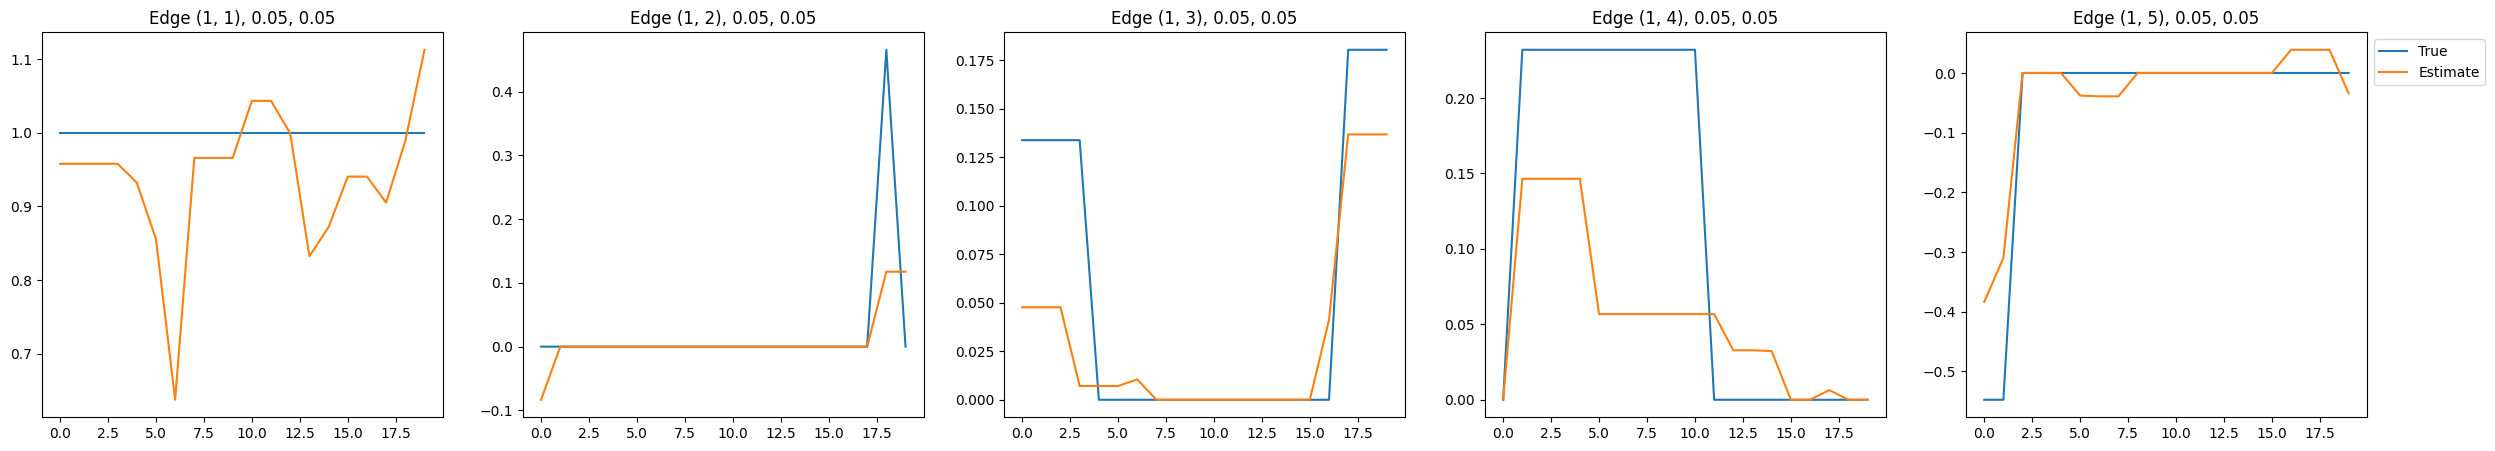

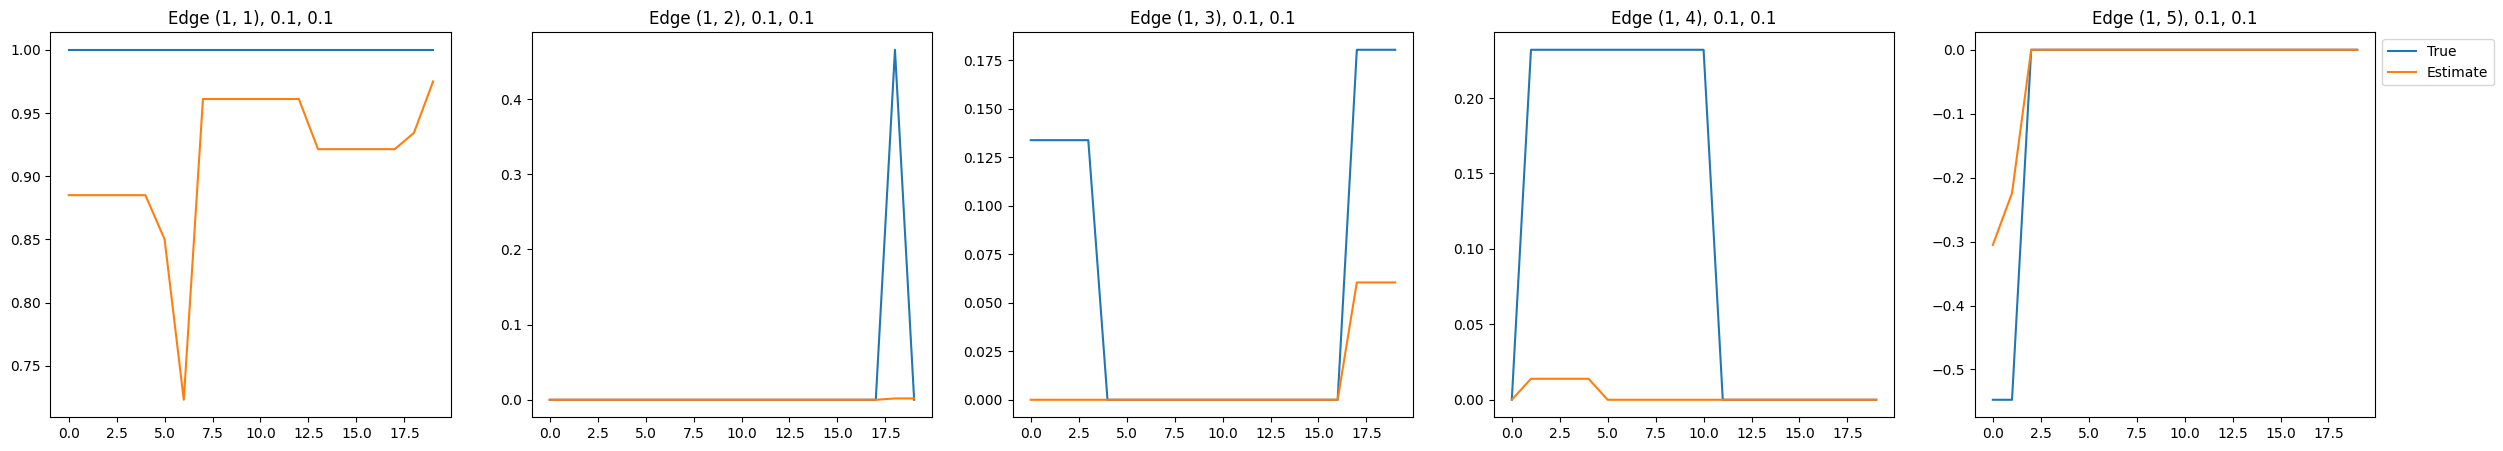

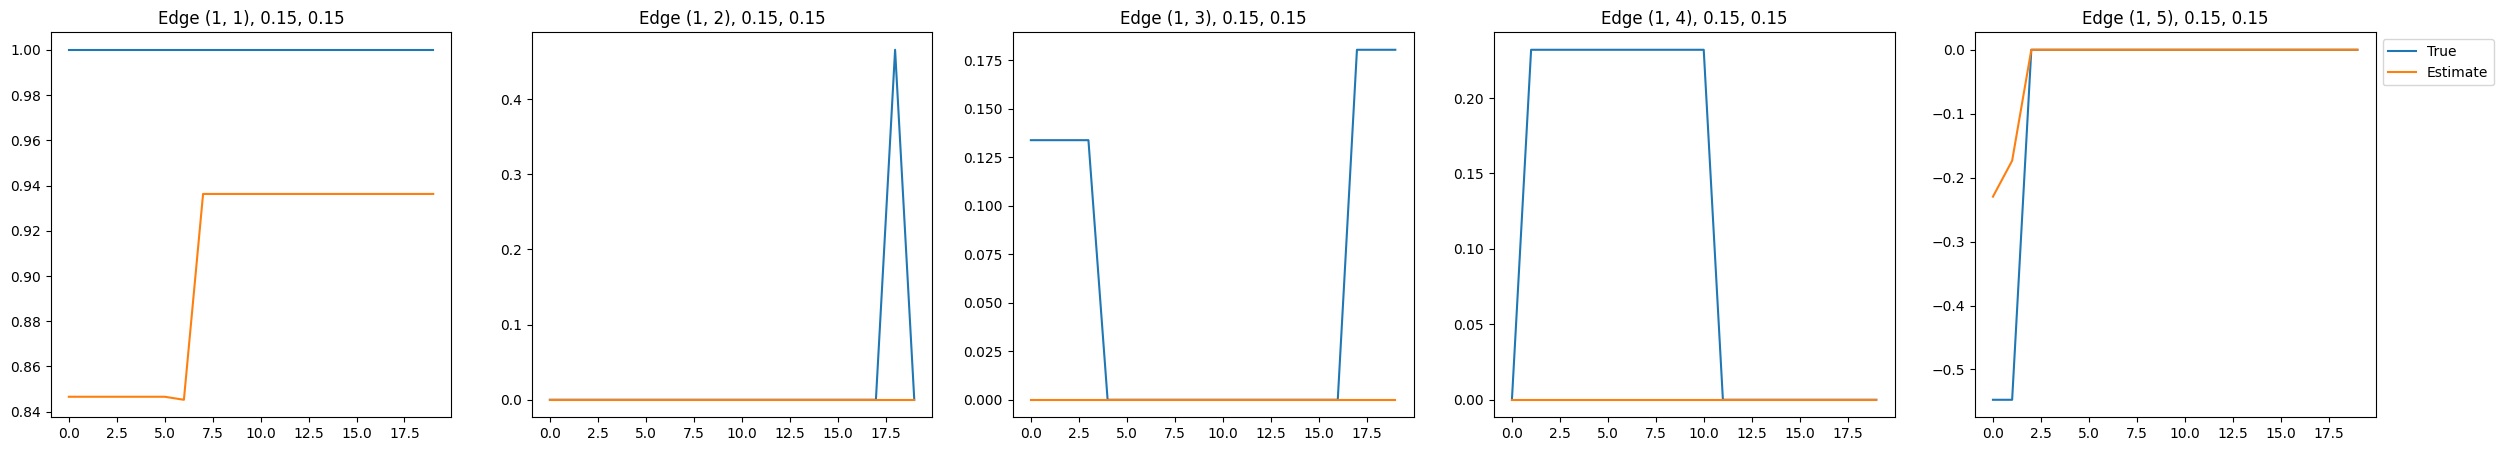

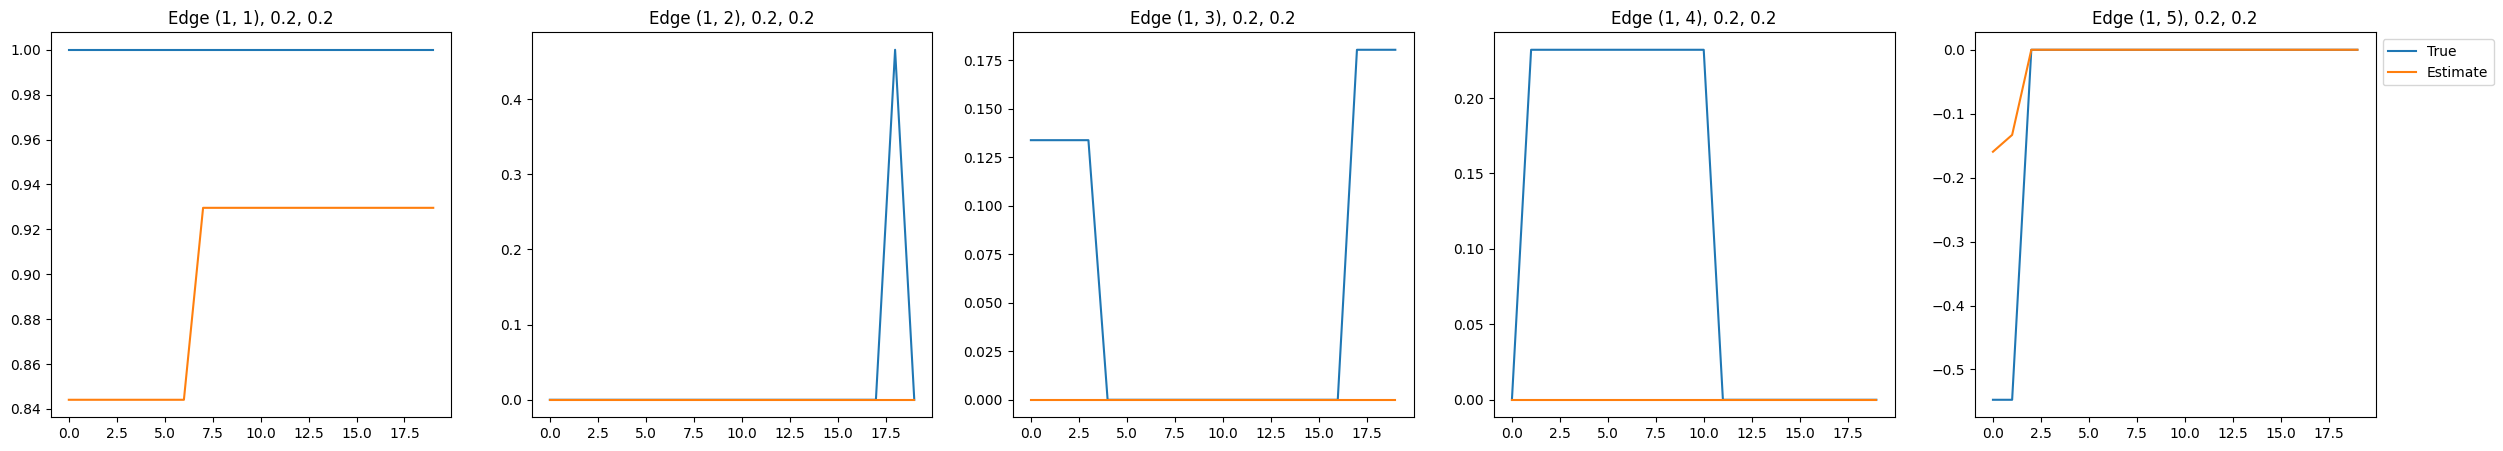

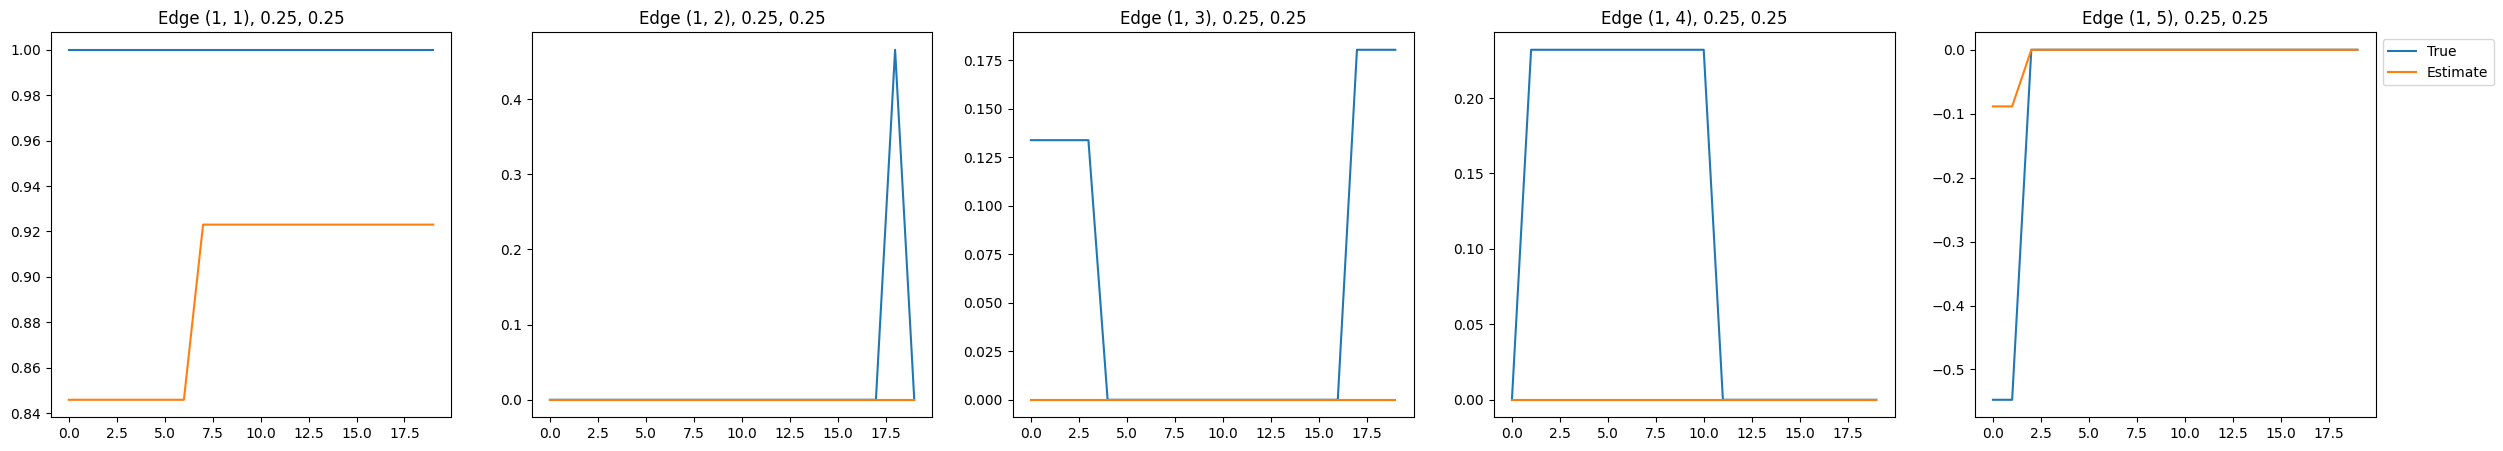

In [189]:

for j in [0, 5, 10, 15, 20, 25]:

    fig, ax = plt.subplots(1,5, figsize = (30,5))

    for i in range(d):
        ax[i].plot(change_point_dict['prec_list'][:,0,i], label = "True")
        ax[i].plot(change_point_dict['theta'][j][j][:,0,i], label = "Estimate")
        if i == d-1:
            ax[i].legend(bbox_to_anchor = (1,1))
        ax[i].set_title(f"Edge ({1}, {i+1}), {np.round(alpha[j],2)}, {np.round(kappa[j],2)}")

Individual

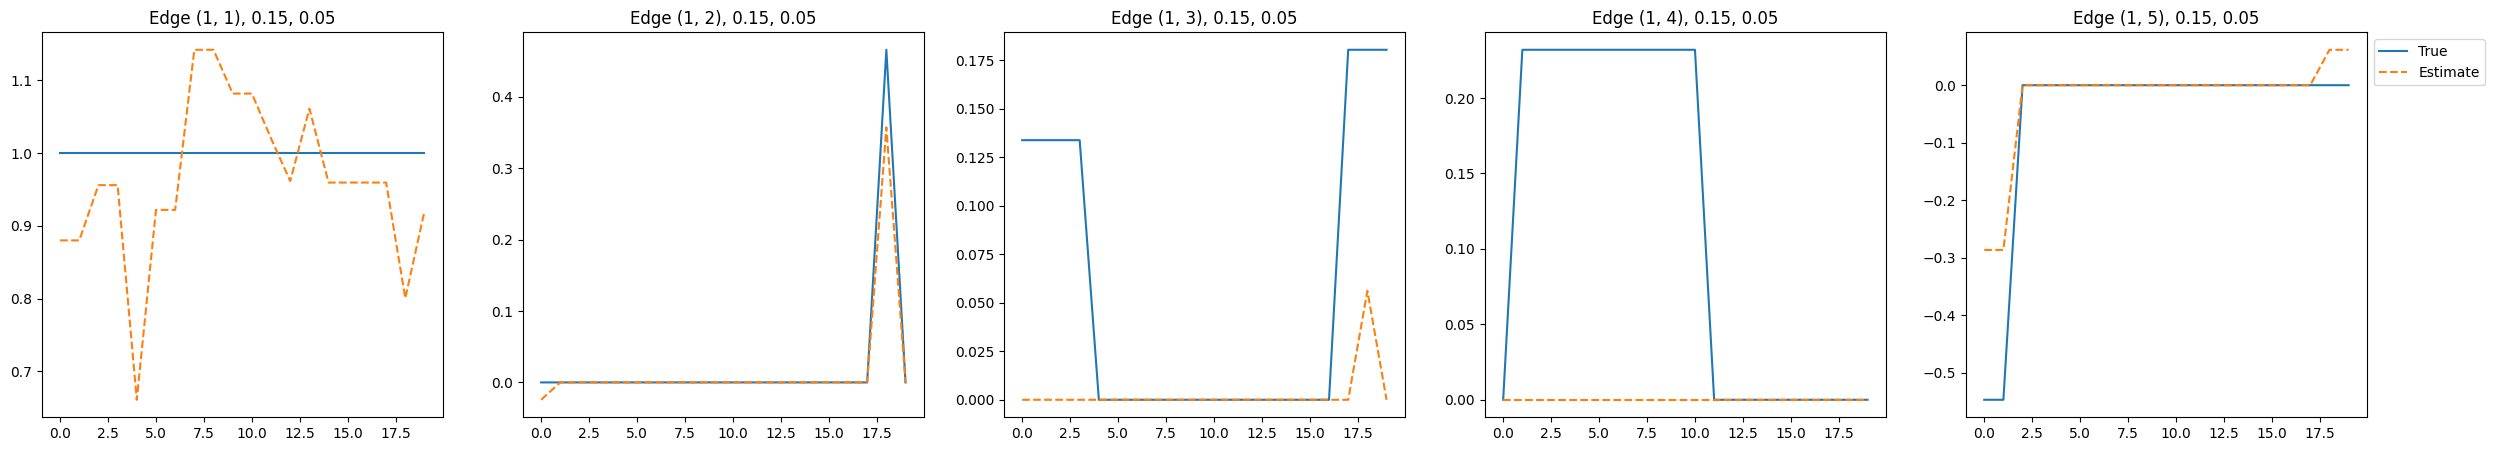

In [187]:
fig, ax = plt.subplots(1,5, figsize = (30,5))

j = 15
k = 5
for i in range(d):
    ax[i].plot(change_point_dict['prec_list'][:,0,i], label = "True")
    ax[i].plot(change_point_dict['theta'][j][k][:,0,i], label = "Estimate", linestyle = 'dashed')
    if i == d-1:
        ax[i].legend(bbox_to_anchor = (1,1))
    ax[i].set_title(f"Edge ({1}, {i+1}), {np.round(alpha[j],2)}, {np.round(kappa[k],2)}")

## Same time step as observations

In [66]:
obs_per_graph_model = nr_obs_per_graph
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph_model, max_iter = 1000, lamda = obs_per_graph_model*0.2, kappa = obs_per_graph_model*0.1, tol = 1e-6)
dg_opt1.fit(Xs, nr_workers=7, temporal_penalty="element-wise", lik_type="gaussian")

Error 1.01E-6:   8%|▊         | 84/1000 [00:00<00:10, 85.78it/s] 


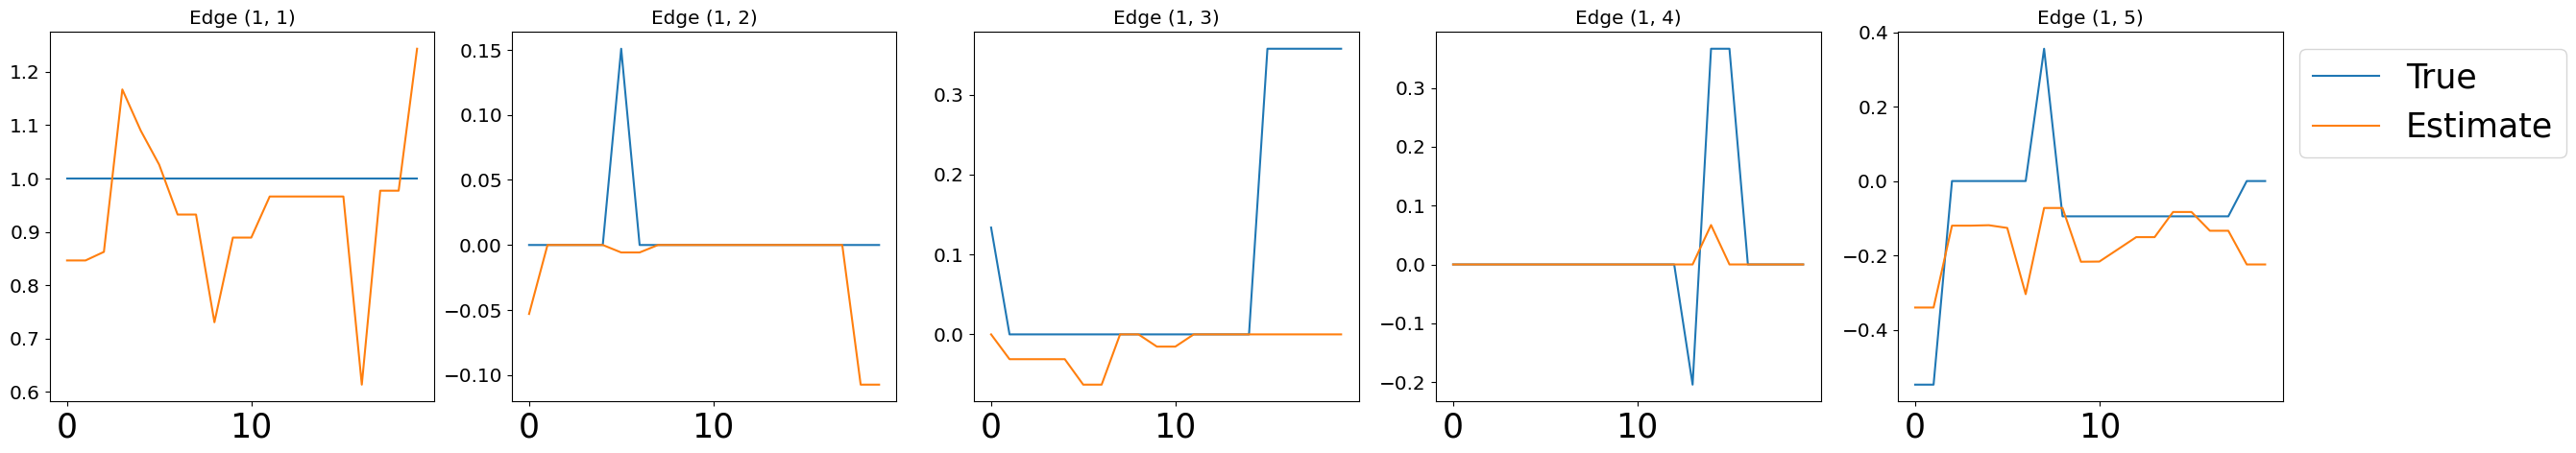

In [67]:
fig, ax = plt.subplots(1,5, figsize = (30,5))


for i in range(d):
    ax[i].plot(prec_list[:,0,i], label = "True")
    ax[i].plot(dg_opt1.theta[:,0,i], label = "Estimate")
    if i == d-1:
        ax[i].legend(bbox_to_anchor = (1,1))
    ax[i].set_title(f"Edge ({1}, {i+1})")

# Single changes not as extreme

In [ ]:
rnd_state = np.random.RandomState(42)

nr_obs_per_graph = 50
n = 9*nr_obs_per_graph
d = prec_0.shape[0]
# Simulate 
Xs = np.zeros((n,d))
prec_list = [prec_0]
is_psd = False
cnt = 0
while cnt*nr_obs_per_graph <n:
    if cnt > 0:
        prec_tmp = prec_list[cnt-1].copy()
        # # element to change
        # i = 0#np.random.randint(0,d)
        # j = rnd_state.randint(0,d)
        # if i == j:
        #     continue
        # if rnd_state.uniform() < 0.8:
        #     prec_tmp[i,j] = 0.0
        #     prec_tmp[j,i] = 0.0
        # else:
        #     w = rnd_state.uniform(-0.5, 0.5)
        #     prec_tmp[i,j] = w
        #     prec_tmp[j,i] = w

        if cnt in [3,4,5]:
            prec_tmp[0,2] = 0.0
            prec_tmp[2,0] = 0.0
        if cnt in [6,7,8]:
            prec_tmp[4,1] = 0.0
            prec_tmp[1,4] = 0.0

        
        u,v = np.linalg.eigh(prec_tmp)
        if np.any(u<0.0):
            continue
        prec_list.append(prec_tmp)

    Xs[cnt*nr_obs_per_graph:(cnt+1)*nr_obs_per_graph ] = rnd_state2.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(prec_list[cnt]),size=(nr_obs_per_graph) )

    cnt +=1




prec_list = np.array(prec_list)



alpha = np.linspace(0,0.6, 10)
kappa = np.linspace(0,0.6, 10)

pbar = tqdm.tqdm(total = len(alpha)*len(kappa))

theta = {i:[] for i in range(len(alpha))}
l1_error = {i:[] for i in range(len(alpha))}
F_error = {i:[] for i in range(len(alpha))}
one_zero_error = {i:[] for i in range(len(alpha))}


obs_per_graph_model = nr_obs_per_graph
for i in range(len(alpha)):
    for j in range(len(kappa)):

        dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph_model, max_iter = 1000, lamda = obs_per_graph_model*alpha[i], kappa = obs_per_graph_model*kappa[j], tol = 1e-6)
        dg_opt1.fit(Xs, nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian", verbose=False)

        theta[i].append(dg_opt1.theta)


        for k in range(int(n/obs_per_graph_model)):
            tmp_F = []
            tmp_zo = []
            tmp_l1 = []

            tmp_zo.append(calc_one_zero_error(prec_list[k], dg_opt1.theta[k]))
            tmp_F.append(scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k],ord = 'fro'))
            tmp_l1.append(scipy.linalg.norm(prec_list[k]- dg_opt1.theta[k],ord = 1))


        F_error[i].append(np.mean(tmp_F))
        one_zero_error[i].append(np.mean(tmp_zo))
        l1_error[i].append(np.mean(tmp_l1))

        pbar.set_description(f"{i} {j}")
        pbar.update()


In [ ]:
d = change_point_dict['theta'][0][0].shape[1]
a_idx = 30
k_idx = 21
fig, ax = plt.subplots(1,1, figsize = (30,5))
i = 0
j = 2
ax.plot(change_point_dict['prec_list'][:,i,j], label = "True")
ax.plot(change_point_dict['theta'][a_idx][k_idx][:,i,j], label = "Estimate")

ax.legend(bbox_to_anchor = (1,1))
ax.set_title(f"Edge ({i+1}, {j+1}), alpha= {np.round(change_point_dict['alpha'][a_idx],2)}, kappa =  {np.round(change_point_dict['kappa'][k_idx],2)}")